In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('valid.csv')

<ipython-input-2-80eeb0dda28d>:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,1450,1451,1452,1453,1454,1649,1650,1

In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB


In [ ]:
print(train.head())
print(test.head())

  report_date  client_id  target  col1  col2  col3  col4  col5  col6  col7  \
0  2022-11-01          1       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  2022-11-01          5       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  2022-05-01          6       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  2022-09-01          7       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  2022-08-01          8       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   ...    col2654    col2655    col2656  col2657  col2658  col2659    col2660  \
0  ...        NaN        NaN        NaN      NaN      NaN      NaN        NaN   
1  ...  7616803.0  7616803.0  7616803.0      NaN      NaN      NaN  7616803.0   
2  ...        NaN        NaN        NaN      NaN      NaN      NaN        NaN   
3  ...        NaN        NaN        NaN      NaN      NaN      NaN        NaN   
4  ...        NaN        NaN        NaN      NaN      NaN      NaN        NaN   

     col2661    col2662   col2663  
0       

In [ ]:
# Проверка пропусков
print(train.isnull().sum())
print(test.isnull().sum())

report_date        0
client_id          0
target             0
col1           14453
col2           14450
               ...  
col2659        13950
col2660         6420
col2661         6420
col2662         6420
col2663            0
Length: 2666, dtype: int64
report_date       0
client_id         0
target            0
col1           3642
col2           3640
               ... 
col2659        3578
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 2666, dtype: int64


In [ ]:
# Выделение числовых признаков
numeric_columns = train.select_dtypes(include=['number']).columns

# Добавляем отсутствующие столбцы в тестовый набор
missing_columns = [col for col in numeric_columns if col not in test.columns]
for col in missing_columns:
    test[col] = np.nan  # Добавляем столбцы с NaN значениями

# Удаляем столбцы, полностью состоящие из NaN
numeric_columns = [col for col in numeric_columns if train[col].notna().any()]

# Импьютер для числовых данных
imputer = SimpleImputer(strategy='median')

# Преобразование числовых данных
train_numeric = pd.DataFrame(imputer.fit_transform(train[numeric_columns]), columns=numeric_columns)
test_numeric = pd.DataFrame(imputer.transform(test[numeric_columns]), columns=numeric_columns)

# Проверка
print(f"Train numeric shape: {train_numeric.shape}")
print(f"Test numeric shape: {test_numeric.shape}")


Train numeric shape: (14456, 2238)
Test numeric shape: (3642, 2238)


In [ ]:
# Подготовка данных для балансировки
X = train_numeric.drop(columns=['target'], errors='ignore')
y = train['target']

# Балансировка классов с использованием SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"Распределение классов после SMOTE:\n{pd.Series(y_balanced).value_counts()}")


Распределение классов после SMOTE:
target
0    14020
1    14020
Name: count, dtype: int64


In [ ]:
# Выделение категориальных признаков
categorical_columns = train.select_dtypes(include=['object']).columns

# Заполнение пропусков в категориальных данных
from sklearn.impute import SimpleImputer
imputer_cat = SimpleImputer(strategy='most_frequent')  # Заполнение наиболее частыми значениями
train[categorical_columns] = imputer_cat.fit_transform(train[categorical_columns])
test[categorical_columns] = imputer_cat.transform(test[categorical_columns])

# Преобразование категориальных данных в строки
train[categorical_columns] = train[categorical_columns].astype(str)
test[categorical_columns] = test[categorical_columns].astype(str)

# One-Hot Encoding для категориальных признаков
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Кодирование категориальных признаков
X_encoded = encoder.fit_transform(train[categorical_columns])
test_encoded = encoder.transform(test[categorical_columns])

print(f"Train encoded shape: {X_encoded.shape}")
print(f"Test encoded shape: {test_encoded.shape}")



Train encoded shape: (14456, 14596)
Test encoded shape: (3642, 14596)


In [ ]:
# Выравниваем столбцы тестовых данных под обучающие
test_numeric = test_numeric[X_balanced.columns]

# Масштабирование числовых признаков
scaler = StandardScaler()

# Применяем масштабирование
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(test_numeric)

print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")


Train scaled shape: (28040, 2237)
Test scaled shape: (3642, 2237)


In [ ]:
# Пример добавления временных признаков
train['report_date'] = pd.to_datetime(train['report_date'])
test['report_date'] = pd.to_datetime(test['report_date'])

train['month'] = train['report_date'].dt.month
train['quarter'] = train['report_date'].dt.quarter

test['month'] = test['report_date'].dt.month
test['quarter'] = test['report_date'].dt.quarter

# Пример агрегатов
train['mean_value'] = train_numeric.mean(axis=1)
test['mean_value'] = test_numeric.mean(axis=1)


In [ ]:
# Финальное разделение данных
X_final = train_numeric.drop(columns=['target'], errors='ignore')
y_final = train['target']

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print("Обучающая выборка готова к моделированию!")
print(f"Train shape: {X_train_final.shape}, Validation shape: {X_val_final.shape}")


Обучающая выборка готова к моделированию!
Train shape: (11564, 2237), Validation shape: (2892, 2237)


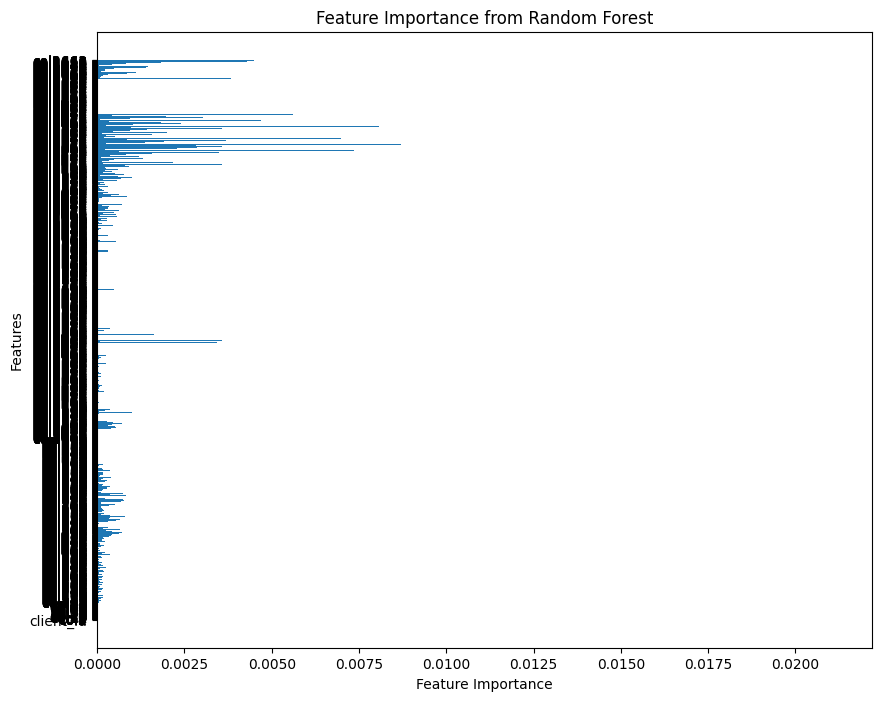

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Обучение базовой модели RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_final, y_train_final)

# Оценка важности признаков
feature_importances = model.feature_importances_
feature_names = X_train_final.columns

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg_scores = cross_val_score(log_reg, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Logistic Regression ROC-AUC: {log_reg_scores.mean():.4f}")

# Градиентный бустинг
gbc = GradientBoostingClassifier(random_state=42)
gbc_scores = cross_val_score(gbc, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Gradient Boosting ROC-AUC: {gbc_scores.mean():.4f}")

# Случайный лес
rf_scores = cross_val_score(model, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Random Forest ROC-AUC: {rf_scores.mean():.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression ROC-AUC: 0.6614
Gradient Boosting ROC-AUC: 0.8626
Random Forest ROC-AUC: 0.9327


In [ ]:
from sklearn.model_selection import GridSearchCV

# Параметры для GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_final, y_train_final)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"ROC-AUC на обучении: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC на обучении: 0.8562


ROC-AUC на валидации: 0.9429


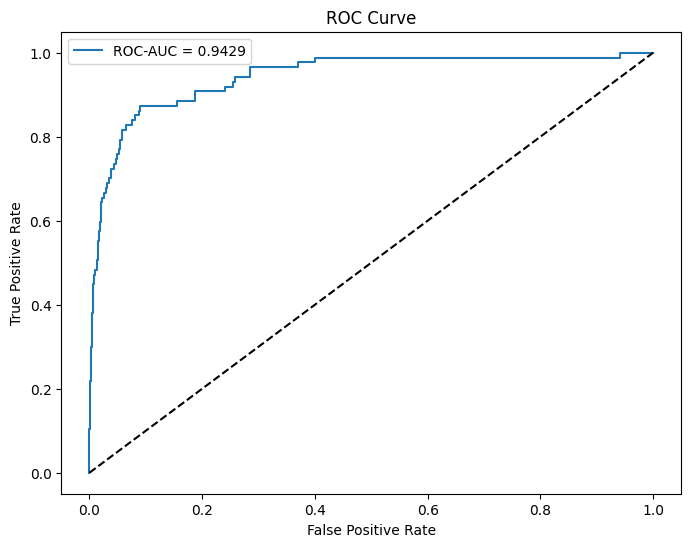

In [ ]:
# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания и оценка
from sklearn.metrics import roc_auc_score, roc_curve

y_val_pred = best_model.predict_proba(X_val_final)[:, 1]
roc_auc = roc_auc_score(y_val_final, y_val_pred)
print(f"ROC-AUC на валидации: {roc_auc:.4f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_val_final, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Предсказания на тестовых данных
test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]

# Сохранение результата
submission = pd.DataFrame({
    'client_id': test['client_id'],
    'score': test_predictions
})
submission.to_csv('submission_file.csv', index=False)

print("Результат сохранён в submission_file.csv")


Результат сохранён в submission_file.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Предсказания на валидационном наборе
y_val_pred = best_model.predict_proba(X_val_final)[:, 1]

# Оценка ROC-AUC
roc_auc = roc_auc_score(y_val_final, y_val_pred)
print(f"ROC-AUC на валидации: {roc_auc:.4f}")

# Подробный отчет по классификации
threshold = 0.5  # Используем стандартный порог
y_val_class = (y_val_pred >= threshold).astype(int)
print(classification_report(y_val_final, y_val_class))


ROC-AUC на валидации: 0.9429
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2805
           1       1.00      0.07      0.13        87

    accuracy                           0.97      2892
   macro avg       0.99      0.53      0.56      2892
weighted avg       0.97      0.97      0.96      2892



In [ ]:
# Предсказания на обучающем наборе
y_train_pred = best_model.predict_proba(X_train_final)[:, 1]
train_roc_auc = roc_auc_score(y_train_final, y_train_pred)

print(f"ROC-AUC на обучении: {train_roc_auc:.4f}")
print(f"Разница ROC-AUC между обучением и валидацией: {train_roc_auc - roc_auc:.4f}")


ROC-AUC на обучении: 0.9922
Разница ROC-AUC между обучением и валидацией: 0.0493


In [ ]:
# Предсказания для тестового набора
test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Создание файла для отправки
submission = pd.DataFrame({
    'client_id': test['client_id'],
    'score': test_predictions
})

# Сохранение файла
submission.to_csv('submission_file.csv', index=False)
print("Результат сохранён в submission_file.csv")


Результат сохранён в submission_file.csv


In [ ]:
# Проверка первых строк файла
print(submission.head())

# Проверка на наличие пропусков
print(submission.isnull().sum())


   client_id     score
0          2  0.424493
1          4  0.412177
2          9  0.415743
3         12  0.420743
4         14  0.424493
client_id    0
score        0
dtype: int64
